## KRILLBASE

KRILLBASE contains pontual records of the post-larval krill density. The data were collected from 1929 to 2016.
We aggregate the krill records on a spatial grid of a resolution of 2°x2° degres // or 0.25°x0.25° like KRILLPODYM resolution.

In [14]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import datetime
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os
#os.chdir('./Key_Areas_krill_carbon_sequestration/data_envir')

### Load the KRILLBASE data

In [86]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/data_envir')

krill_base = pd.read_excel('krillbase_data.xlsx')
krill_base # 14 734 rows × 29 columns

,STATION,RECORD_TYPE,NUMBER_OF_STATIONS,NUMBER_OF_NETS,LATITUDE,LONGITUDE,SEASON,DAYS_FROM_1ST_OCT,DATE,DATE_ACCURACY,...,N_OR_S_POLAR_FRONT,WATER_DEP_MEAN_WITHIN_10KM,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,SD_OF_SURVEY_MEAN_KRILL,NUMBER_OF_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2,CAVEATS,NUMBER_OF_SALPS_UNDER_1M2,SOURCE
0,ake2008sars16,haul,1.0,1.0,-51.9880,-25.0040,2008.0,107.0,2008-01-15,M,...,S,3602.732673,763.0,4.298100,NaN,0.087508,0.116,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
1,ake2008sars17,haul,1.0,1.0,-52.3310,-18.1600,2008.0,107.0,2008-01-15,M,...,N,4231.476285,143.0,3.819259,NaN,0.000000,0.000,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
2,ake2008sars22,haul,1.0,1.0,-57.5340,-7.4940,2008.0,107.0,2008-01-15,M,...,S,2726.067327,1427.0,1.036612,NaN,0.485498,1.454,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
3,ake2008sars23,haul,1.0,1.0,-58.7590,-6.2200,2008.0,107.0,2008-01-15,M,...,S,3905.786982,1299.0,0.807276,NaN,12.948638,38.784,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
4,ake2008sars24,haul,1.0,1.0,-58.7590,-0.0370,2008.0,107.0,2008-01-15,M,...,S,4391.713439,428.0,0.833557,NaN,101.965050,305.411,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,vsi2004lak1113,haul,1.0,1.0,-62.0000,-1.9833,2004.0,208.0,2004-04-25,D,...,S,5270.206759,384.0,0.786577,NaN,0.000000,0.000,NaN,0.000000,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14730,vsi2004lak1114,haul,1.0,1.0,-62.3167,-2.0000,2004.0,208.0,2004-04-25,D,...,S,5299.237154,131.0,0.786506,NaN,16.387810,68.804,NaN,0.000000,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14731,vsi2004lak1115,haul,1.0,1.0,-62.6667,-2.0167,2004.0,209.0,2004-04-26,D,...,S,5241.013889,120.0,0.784432,NaN,12.094240,52.062,Warning: winter sample date.,0.086853,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14732,vsi2004lak1116,haul,1.0,1.0,-63.0000,-2.0000,2004.0,209.0,2004-04-26,D,...,S,5205.778443,73.0,0.778599,NaN,23.064810,99.287,Warning: winter sample date.,0.557238,"German data (LAKRIS cruise), V. Siegel, pers. ..."


# Procedure to clean KRILLBASE
KRILLBASE data are cleaned following these steps:
1. Select columns of interest in the initial data set 
2. Select records from 1976
3. Filter NaN in standardized density of krill
4. Filter records with shallowest sampling depth <20m and deepest sampling depth > 50m
5. Filter for summer data (all standardized data should be between October and March included)
6. Filter for records south of the polar front

In [88]:
# 1. interest columns
krill_base = krill_base[['STATION', 'DATE', 'DATE_ACCURACY', 
                'LATITUDE', 'LONGITUDE',
                'N_OR_S_POLAR_FRONT',
                'TOP_SAMPLING_DEPTH_M', 'BOTTOM_SAMPLING_DEPTH_M',
                'STANDARDISED_KRILL_UNDER_1M2',
                'NUMBER_OF_KRILL_UNDER_1M2',
                'WATER_DEP_MEAN_WITHIN_10KM',
                'WATER_DEPTH_RANGE_WITHIN_10KM',
                'CLIMATOLOGICAL_TEMPERATURE']]

#typo in column
krill_base = krill_base.rename(columns = {'WATER_DEP_MEAN_WITHIN_10KM' : 'WATER_DEPTH_MEAN_WITHIN_10KM'})


# 2. create new columns to store Year and Month of the records
krill_base['DATE'] = pd.to_datetime(krill_base.DATE)
krill_base['YEAR'] = krill_base['DATE'].dt.year
krill_base['MONTH'] = krill_base['DATE'].dt.month

# 3. Filter NaN in standardized density of krill
krill_base = krill_base.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2']) # 10102 

# 4. Filter for depth of sampling <20m and > 50m and removes "survey means" and "stratified hauls"
krill_base = krill_base[(krill_base['RECORD_TYPE'] == 'haul') | (krill_base['RECORD_TYPE'] == 'stratified pooled haul')]
krill_base = krill_base[(krill_base['TOP_SAMPLING_DEPTH_M'] < 20) & (krill_base['BOTTOM_SAMPLING_DEPTH_M'] > 50)] # 9425 

# 5. Filter for summer data (all standardized data should be between October and March included)
krill_base = krill_base[(krill_base['MONTH'] >= 10) | (krill_base['MONTH'] <= 3)] #  

# 6. Filter south of polar front
krill_base = krill_base[krill_base['N_OR_S_POLAR_FRONT'] == 'S'] 
krill_base #  10431 


,STATION,DATE,DATE_ACCURACY,LATITUDE,LONGITUDE,N_OR_S_POLAR_FRONT,TOP_SAMPLING_DEPTH_M,BOTTOM_SAMPLING_DEPTH_M,STANDARDISED_KRILL_UNDER_1M2,NUMBER_OF_KRILL_UNDER_1M2,WATER_DEPTH_MEAN_WITHIN_10KM,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,YEAR,MONTH
0,ake2008sars16,2008-01-15,M,-51.9880,-25.0040,S,0.0,771.0,0.116,0.087508,3602.732673,763.0,4.298100,2008.0,1.0
2,ake2008sars22,2008-01-15,M,-57.5340,-7.4940,S,0.0,757.0,1.454,0.485498,2726.067327,1427.0,1.036612,2008.0,1.0
3,ake2008sars23,2008-01-15,M,-58.7590,-6.2200,S,0.0,760.0,38.784,12.948638,3905.786982,1299.0,0.807276,2008.0,1.0
4,ake2008sars24,2008-01-15,M,-58.7590,-0.0370,S,0.0,790.0,305.411,101.965050,4391.713439,428.0,0.833557,2008.0,1.0
5,ake2008sars25,2008-02-14,M,-56.2070,-0.0530,S,0.0,750.0,186.117,50.631877,3735.085657,1367.0,0.996215,2008.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14636,vsi2001ste82,2001-01-28,D,-61.5000,-54.1833,S,0.0,194.0,3.188,1.241600,712.455621,861.0,0.719545,2001.0,1.0
14637,vsi2001ste83,2001-01-28,D,-61.7500,-54.2167,S,0.0,196.0,0.483,0.188160,446.390963,608.0,0.719545,2001.0,1.0
14638,vsi2001ste93,2001-01-28,D,-62.0000,-54.0000,S,0.0,197.0,15.162,5.900150,556.061265,243.0,0.436525,2001.0,1.0
14639,vsi2001ste95,2001-01-29,D,-62.0667,-55.0500,S,0.0,206.0,20.091,7.757960,852.482283,998.0,0.586243,2001.0,1.0


# Spatial Aggregation of the krill records

In [104]:
# round the coordinated of the data 
def round_acc(x, accuracy):
    return round(x / accuracy) * accuracy

def round_coord_ocim(y) :
    if np.trunc(y) % 2 == 0 : # if integer part is even
        return(np.trunc(y)+1)
    else :
        return(np.trunc(y))
    

# add lat long of OICM grid
krill_base['LONGITUDE_ocimgrid'] = krill_base['LONGITUDE'].apply(round_coord_ocim)
krill_base['LATITUDE_ocimgrid'] = krill_base['LATITUDE'].apply(round_coord_ocim)

#add lat long of 2x6° grid
krill_base['LONGITUDE_largegrid'] = krill_base['LONGITUDE'].apply(lambda x: round_acc(x, accuracy=6))
krill_base['LATITUDE_largegrid'] = krill_base['LATITUDE'].apply(round_coord_ocim)

krill_base 

,STATION,DATE,DATE_ACCURACY,LATITUDE,LONGITUDE,N_OR_S_POLAR_FRONT,TOP_SAMPLING_DEPTH_M,BOTTOM_SAMPLING_DEPTH_M,STANDARDISED_KRILL_UNDER_1M2,NUMBER_OF_KRILL_UNDER_1M2,...,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,YEAR,MONTH,LONGITUDE_smallgrid,LATITUDE_smallgrid,LONGITUDE_ocimgrid,LATITUDE_ocimgrid,LONGITUDE_largegrid,LATITUDE_largegrid
0,ake2008sars16,2008-01-15,M,-51.9880,-25.0040,S,0.0,771.0,0.116,0.087508,...,763.0,4.298100,2008.0,1.0,-27,-53,-25.0,-51.0,-24,-51.0
2,ake2008sars22,2008-01-15,M,-57.5340,-7.4940,S,0.0,757.0,1.454,0.485498,...,1427.0,1.036612,2008.0,1.0,-9,-59,-7.0,-57.0,-6,-57.0
3,ake2008sars23,2008-01-15,M,-58.7590,-6.2200,S,0.0,760.0,38.784,12.948638,...,1299.0,0.807276,2008.0,1.0,-7,-59,-5.0,-57.0,-6,-57.0
4,ake2008sars24,2008-01-15,M,-58.7590,-0.0370,S,0.0,790.0,305.411,101.965050,...,428.0,0.833557,2008.0,1.0,-1,-59,1.0,-57.0,0,-57.0
5,ake2008sars25,2008-02-14,M,-56.2070,-0.0530,S,0.0,750.0,186.117,50.631877,...,1367.0,0.996215,2008.0,2.0,-1,-57,1.0,-55.0,0,-55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14636,vsi2001ste82,2001-01-28,D,-61.5000,-54.1833,S,0.0,194.0,3.188,1.241600,...,861.0,0.719545,2001.0,1.0,-55,-63,-53.0,-61.0,-54,-61.0
14637,vsi2001ste83,2001-01-28,D,-61.7500,-54.2167,S,0.0,196.0,0.483,0.188160,...,608.0,0.719545,2001.0,1.0,-55,-63,-53.0,-61.0,-54,-61.0
14638,vsi2001ste93,2001-01-28,D,-62.0000,-54.0000,S,0.0,197.0,15.162,5.900150,...,243.0,0.436525,2001.0,1.0,-55,-63,-53.0,-61.0,-54,-61.0
14639,vsi2001ste95,2001-01-29,D,-62.0667,-55.0500,S,0.0,206.0,20.091,7.757960,...,998.0,0.586243,2001.0,1.0,-57,-63,-55.0,-61.0,-54,-61.0


## Convert in xarray format and then interpolated onto the "OCIM grid" (i.e., a 2°x2° grid with cells centers on odd numbers)

In [155]:
# With ocim grid
krill_base_grouped = krill_base[['LONGITUDE_ocimgrid', 'LATITUDE_ocimgrid', 'STANDARDISED_KRILL_UNDER_1M2']].groupby(['LONGITUDE_ocimgrid', 'LATITUDE_ocimgrid']).mean()
krill_base_grouped # 715

# with large grid
krill_base_grouped_largegrid = krill_base[['LONGITUDE_largegrid', 'LATITUDE_largegrid', 'STANDARDISED_KRILL_UNDER_1M2']].groupby(['LONGITUDE_largegrid', 'LATITUDE_largegrid']).mean()
krill_base_grouped_largegrid # 358 

STANDARDISED_KRILL_UNDER_1M2
LONGITUDE_largegrid LATITUDE_largegrid                              
-180                -69.0                                   0.000000
                    -67.0                                   0.000000
                    -61.0                                  21.669000
-174                -71.0                                   0.177667
                    -67.0                                   0.000000
...                                                              ...
 174                -61.0                                   0.000000
 180                -73.0                                   0.000000
                    -71.0                                   0.000000
                    -67.0                                   0.000000
                    -61.0                                   0.000000

[358 rows x 1 columns]

In [156]:
krill_base_xarray = xr.Dataset.from_dataframe(krill_base_grouped)
krill_base_xarray
#xr_spatial_em = xr.Dataset.to_array(xr_spatial_em) 
#krill_base_xarray['STANDARDISED_KRILL_UNDER_1M2']


krill_base_xarray_largegrid = xr.Dataset.from_dataframe(krill_base_grouped_largegrid)
krill_base_xarray_largegrid

<xarray.Dataset>
Dimensions:                       (LONGITUDE_largegrid: 61,
                                   LATITUDE_largegrid: 16)
Coordinates:
  * LONGITUDE_largegrid           (LONGITUDE_largegrid) int64 -180 -174 ... 180
  * LATITUDE_largegrid            (LATITUDE_largegrid) float64 -77.0 ... -47.0
Data variables:
    STANDARDISED_KRILL_UNDER_1M2  (LONGITUDE_largegrid, LATITUDE_largegrid) float64 ...

## For the data aggregated on the "large grid", interpolate (resample) on OICM grid

In [157]:
new_lat = np.arange(-77, -45, 2) # create desired latitude and longitude vectors (start at -79 to match the OCIM coords wich are 2°x2° on odd numbers)
new_lon = np.arange(-179, 180, 2) # same for longitude

krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid.interp(LATITUDE_largegrid=new_lat, LONGITUDE_largegrid=new_lon, method="nearest")

In [158]:
# log of krill density
def my_log(x):
    return np.log10(x+1)
    
krill_base_xarray = krill_base_xarray.assign(STANDARDISED_KRILL_UNDER_1M2_log = my_log(krill_base_xarray['STANDARDISED_KRILL_UNDER_1M2']))
krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid_interpolated.assign(STANDARDISED_KRILL_UNDER_1M2_log = my_log(krill_base_xarray_largegrid_interpolated['STANDARDISED_KRILL_UNDER_1M2']))

# transpose (if not lat and long are inverted when ploting)
krill_base_xarray = krill_base_xarray.transpose()
krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid_interpolated.transpose()

Text(0.5, 1.0, 'Map of krill density - KRILLBASE')

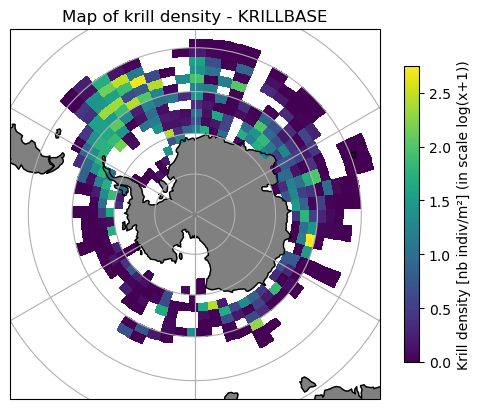

In [159]:
map_proj = ccrs.SouthPolarStereo()

p = krill_base_xarray_largegrid_interpolated["STANDARDISED_KRILL_UNDER_1M2_log"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "viridis"
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill density [nb indiv/m²] (in scale log(x+1))', shrink = 0.8)
plt.title('Map of krill density - KRILLBASE')

Text(0.5, 1.0, 'Map of krill density - KRILLBASE')

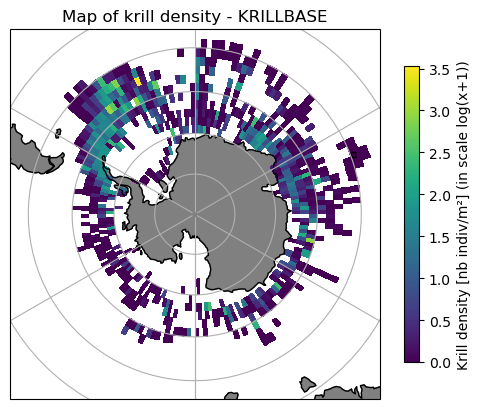

In [160]:
map_proj = ccrs.SouthPolarStereo()

p = krill_base_xarray["STANDARDISED_KRILL_UNDER_1M2_log"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "viridis"
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill density [nb indiv/m²] (in scale log(x+1))', shrink = 0.8)
plt.title('Map of krill density - KRILLBASE')

In [161]:
krill_base_df = krill_base_xarray.to_dataframe()
krill_base_df.describe()

,STANDARDISED_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2_log
count,715.000000,715.000000
mean,23.838183,0.505156
std,146.296246,0.692435
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.319000,0.120245
75%,6.773839,0.890629
max,3358.305000,3.526249


In [162]:
krill_base_largegrid_df = krill_base_xarray_largegrid_interpolated.to_dataframe()
krill_base_largegrid_df.describe()

,STANDARDISED_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2_log
count,1063.000000,1063.000000
mean,18.299590,0.563192
std,56.239399,0.691938
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.530333,0.184786
75%,8.889526,0.995160
max,553.677333,2.744040


### Save

In [163]:
# Save the dataframe as csv in git hub repo
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')
krill_base_largegrid_df.to_csv('Krill_density_krillbase_df_final.csv')

In [164]:
#save files
# save netcdf in local bc too heavy for git hub
krill_base_xarray_largegrid_interpolated.to_netcdf('Krill_density_krillbase_final.nc')